# AustinTrafficPy

## Team5_And_Dime (MWSa)

* Andry Dominguez
* Tony Jones
* Brian Stoller
* Ali Apil
* Eric Staveley

Tasks managed at:  
https://trello.com/b/MadPBixY/trafficpy-team5

Team project repo:
https://github.com/ericcuda/team5_and_dime


## Presentation Agenda
(presentation will be within the Jupyter Notebook files)

* Eric Staveley - Intro / Extract Transform, Load (ETL) Process
* Tony Jones - Dive Into Date & Rush/Non-Rush Hour Implications
* Andry Dominguez - Poisson Distribution and Statistical Observations
* Ali Apil - Fatality Analysis Extraction
* Brian Stoller - Heat Maps and Additional Analysis
* Team:  Conclusion, Post Mortem, Recognition to Manny/TA's

### Null Hypothesis
The only significant contributing factor to vehicle accident rate is congestion.

### Hypothesis
Day of the week, temperature, or hours of daylight (mood) have a significant influence on vehicle accident rates.

### Scope
Investigate Austin area accidents, traffic flows data, weather conditions, road conditions
(Per Jonathan's suggestion, the hypothesis is solid, the difficulty in this project is the data scope and acquisition.
Look to limit to just Austin, or compare to other cities in Texas, at a higher level.)

#### Data Sources:
* data.austintexas.gov  (Real Time Traffic Incident Data)  <narrowed down timeframe to 2018>
* Could not find *free* historial weather data for 2018.  Purchased 3 years of data from OpenWeatherMap incl 2018. $10


In [1]:
# !pip install plotly

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import plotly as py
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
import gmaps


# import API keys as needed, incl Google developer
from api_keys import gkey

# Access maps with unique API key
gmaps.configure(api_key=gkey)

# Incorporated citipy to determine city based on latitude and longitude
#from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/aus_traffic.csv"

#get current time
now = datetime.datetime.now()


#  Incidents ETL Starts Here

In [3]:
#EXTRACT, TRANSFORM, LOAD
#csv method...since we could get a larger dataset
data_file = "Resources/Real-Time_Traffic_Incident_Reports.csv"

#construct the df
df_from_csv = pd.read_csv(data_file)
print(f"Raw data incident record count: {len(df_from_csv)}")
df_from_csv.head()

Raw data incident record count: 98324


,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,06/13/2018 06:35:59 AM +0000,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,06/13/2018 09:00:03 AM +0000
1,2664C206999E7419517EE39E177797576A52201B_15381...,09/29/2018 12:52:58 AM +0000,Traffic Hazard,"(30.380525,-97.737873)",30.380525,-97.737873,0 Mopac Sb To Research Sb Ramp,ARCHIVED,09/29/2018 01:35:03 AM +0000
2,5BB246A3223A89C7FB9B2EED9A2EBDA82141406D_15438...,12/03/2018 05:49:02 PM +0000,Crash Service,"(30.278372,-97.671971)",30.278372,-97.671971,5800 Techni Center Dr,ARCHIVED,12/03/2018 06:30:03 PM +0000
3,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,06/13/2018 10:15:36 AM +0000,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,06/13/2018 11:20:03 AM +0000
4,7FD2528A7609AAECB6AF825AC275F98CFDFFF8AD_15382...,09/29/2018 12:47:30 PM +0000,Traffic Hazard,"(30.281659,-97.728551)",30.281659,-97.728551,0 N Ih 35 Ud Sb To Mlk Ramp,ARCHIVED,09/29/2018 01:00:03 PM +0000


In [4]:
#clean up the data in incident df

#get rid of the NaNs found in Location
#19	9BD7909EA32C89F68E82ED0CBE1F30A2E1D72B1C_15323...	07/23/2018 09:39:17 PM +0000	zSTALLED VEHICLE	NaN	0.000000	0.000000	3339 W BRAKER LN	ARCHIVED	07/23/2018 10:15:02 PM +0000

print(f"Non-NA values per column:\n{df_from_csv.count()}")   #show the non-NA cells for each field

#remove the rows with any empty cells
df_from_csv_clean = df_from_csv.dropna(how='any')

print(f"Total of rows with complete data now: {len(df_from_csv_clean)}")

print("Removing invalid longitude and latitude...")
#ensure lat and long are valid.  -90<=lat<=90     -180<=lon<=180
#lat
row_condition = df_from_csv_clean["Latitude"] <= 90
filtered_df = df_from_csv_clean.loc[row_condition]
row_condition = filtered_df["Latitude"] >= -90
filtered_df = filtered_df.loc[row_condition]

#long
row_condition = filtered_df["Longitude"] <= 180
filtered_df = filtered_df.loc[row_condition]
row_condition = filtered_df["Longitude"] >= -180
filtered_df = filtered_df.loc[row_condition]

print(f"Total number of rows with valid lat/long data: {len(filtered_df)}")
df_from_csv_clean = filtered_df   #re-assign filtered df back to our orig name

df_from_csv_clean.dtypes

Non-NA values per column:
Traffic Report ID    98324
Published Date       98324
Issue Reported       98324
Location             98045
Latitude             98245
Longitude            98245
Address              98324
Status               96631
Status Date          98324
dtype: int64
Total of rows with complete data now: 96358
Removing invalid longitude and latitude...
Total number of rows with valid lat/long data: 96352


Traffic Report ID     object
Published Date        object
Issue Reported        object
Location              object
Latitude             float64
Longitude            float64
Address               object
Status                object
Status Date           object
dtype: object

In [5]:
df_from_csv_clean.count() 

Traffic Report ID    96352
Published Date       96352
Issue Reported       96352
Location             96352
Latitude             96352
Longitude            96352
Address              96352
Status               96352
Status Date          96352
dtype: int64

In [6]:
#convert the date strings in the DF to valid datetime types
df_from_csv_clean['Published Date'] =  pd.to_datetime(df_from_csv_clean['Published Date'])
#df_from_csv_clean.head()
df_from_csv_clean['Status Date'] =  pd.to_datetime(df_from_csv_clean['Status Date'])
df_from_csv_clean.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,C163BCD1CF90C984E9EDA4DBA311BCA369A7D1A1_15288...,2018-06-13 06:35:59,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,ARCHIVED,2018-06-13 09:00:03
1,2664C206999E7419517EE39E177797576A52201B_15381...,2018-09-29 00:52:58,Traffic Hazard,"(30.380525,-97.737873)",30.380525,-97.737873,0 Mopac Sb To Research Sb Ramp,ARCHIVED,2018-09-29 01:35:03
2,5BB246A3223A89C7FB9B2EED9A2EBDA82141406D_15438...,2018-12-03 17:49:02,Crash Service,"(30.278372,-97.671971)",30.278372,-97.671971,5800 Techni Center Dr,ARCHIVED,2018-12-03 18:30:03
3,6B20382196FB454E9FD06A33E60142902A2F0706_15288...,2018-06-13 10:15:36,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,ARCHIVED,2018-06-13 11:20:03
4,7FD2528A7609AAECB6AF825AC275F98CFDFFF8AD_15382...,2018-09-29 12:47:30,Traffic Hazard,"(30.281659,-97.728551)",30.281659,-97.728551,0 N Ih 35 Ud Sb To Mlk Ramp,ARCHIVED,2018-09-29 13:00:03


In [7]:
#peek at the earliest and latest incident date in our DF
earliest_date = min(df_from_csv_clean["Published Date"])
print(f"Earliest date for incidents: {earliest_date}")
latest_date = max(df_from_csv_clean["Published Date"])
print(f"Latest date for incidents: {latest_date}")
type(latest_date)     #confirm the type

df_from_csv_clean.dtypes


Earliest date for incidents: 2017-09-26 16:11:00
Latest date for incidents: 2019-03-06 02:37:18


Traffic Report ID            object
Published Date       datetime64[ns]
Issue Reported               object
Location                     object
Latitude                    float64
Longitude                   float64
Address                      object
Status                       object
Status Date          datetime64[ns]
dtype: object

In [8]:
#use only 2018 data now
#keep only 2018 data
row_condition = df_from_csv_clean["Published Date"] <= "2018-12-31 23:59:59"
filtered_df = df_from_csv_clean.loc[row_condition]
row_condition = filtered_df["Published Date"] >= "2018-01-01 00:00:01"
filtered_df = filtered_df.loc[row_condition]

print(f"Total number of rows with 2018 incident data  {len(filtered_df)}")

earliest_date = min(filtered_df["Published Date"])
print(f"Earliest date: {earliest_date}")
latest_date = max(filtered_df["Published Date"])
print(f"Latest date: {latest_date}")

df_from_csv_clean = filtered_df   #re-assign filtered df back to our orig name

Total number of rows with 2018 incident data  68244
Earliest date: 2018-01-01 00:07:00
Latest date: 2018-12-31 23:41:17


In [9]:
#look at types of accidents and counts
df_from_csv_clean["Issue Reported"].value_counts()

Traffic Hazard                20272
Crash Urgent                  15411
Crash Service                 11343
COLLISION                      4793
Traffic Impediment             4745
TRFC HAZD/ DEBRIS              4060
zSTALLED VEHICLE               3008
COLLISION WITH INJURY          1573
LOOSE LIVESTOCK                1471
COLLISN/ LVNG SCN              1000
COLLISION/PRIVATE PROPERTY      250
VEHICLE FIRE                    145
BLOCKED DRIV/ HWY                93
ICY ROADWAY                      21
BOAT ACCIDENT                    20
AUTO/ PED                        15
TRAFFIC FATALITY                 11
FLEET ACC/ INJURY                 9
N / HZRD TRFC VIOL                2
HIGH WATER                        1
COLLISN / FTSRA                   1
Name: Issue Reported, dtype: int64

In [10]:
#clean up col names,  and make "Other" from bott group
renamed_df = df_from_csv_clean.replace({"HIGH WATER" : "OTHER", "COLLISN / FTSRA":"OTHER", "N / HZRD TRFC VIOL":"OTHER","FLEET ACC/ INJURY":"OTHER" , "AUTO/ PED" : "OTHER", "BOAT ACIDENT":"OTHER", "ICY ROADWAY":"OTHER","BLOCKED DRIV/ HWY":"OTHER" })
df_from_csv_clean = renamed_df.replace({"zSTALLED VEHICLE" : "STALLED VEHICLE", "Traffic Hazard":"TRAFFIC HAZARD", "Crash Urgent":"CRASH URGENT", "Crash Service":"CRASH SERVICE", "Traffic Impediment":"TRAFFIC IMPEDIMENT"  })

filtered_df = df_from_csv_clean

#Verify cleanup
df_from_csv_clean["Issue Reported"].value_counts()
x= df_from_csv_clean["Issue Reported"].value_counts()
print(x)
#x[0]
#x[1]
#we now will dive into 
#'Crash Urgent', 'Crash Service', 'COLLISION', 'COLLISION WITH INJURY', 'COLLISN/ LVNG SCN', 'COLLISION/Private Property', 'TRAFFIC FATALITY')
#print(f"Total number of rows with 2018 data  {len(renamed_df)}")

TRAFFIC HAZARD                20272
CRASH URGENT                  15411
CRASH SERVICE                 11343
COLLISION                      4793
TRAFFIC IMPEDIMENT             4745
TRFC HAZD/ DEBRIS              4060
STALLED VEHICLE                3008
COLLISION WITH INJURY          1573
LOOSE LIVESTOCK                1471
COLLISN/ LVNG SCN              1000
COLLISION/PRIVATE PROPERTY      250
VEHICLE FIRE                    145
OTHER                           142
BOAT ACCIDENT                    20
TRAFFIC FATALITY                 11
Name: Issue Reported, dtype: int64


([<matplotlib.patches.Wedge at 0x94c5c22208>,
 [Text(-1.166993757679846, -0.2795095160030752, 'TRAFFIC HAZARD'),
  Text(0.33236167117831206, -1.0485874877813295, 'CRASH URGENT'),
  Text(1.0994283816649344, -0.03545748989457086, 'CRASH SERVICE'),
  Text(0.8337846585299421, 0.7174978349793873, 'COLLISION'),
  Text(0.4496821428952587, 1.003885436870726, 'TRAFFIC IMPEDIMENT'),
  Text(0.017385122560072123, 1.099862608471427, 'TRFC HAZD/ DEBRIS'),
  Text(-0.3351119265076546, 1.0477117908625104, 'STALLED VEHICLE'),
  Text(-0.5470005370705541, 0.954353400184924, 'COLLISION WITH INJURY'),
  Text(-0.6749347486261855, 0.8685983450921996, 'LOOSE LIVESTOCK'),
  Text(-0.7691644603631717, 0.7863752494288151, 'COLLISN/ LVNG SCN'),
  Text(-0.8131170926017822, 0.7408377647763543, 'COLLISION/PRIVATE PROPERTY'),
  Text(-0.826453105280294, 0.7259306198064382, 'VEHICLE FIRE'),
  Text(-0.8359716634535844, 0.7149485141621369, 'OTHER'),
  Text(-0.8412801838023155, 0.7086943292714727, 'BOAT ACCIDENT'),
  Text(-

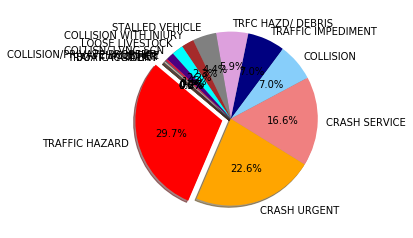

In [11]:
#type(x)
#print(x[0])
#print(x)
#print(x.index)
#type(x.index)
 
labels = df_from_csv_clean['Issue Reported'].value_counts().index
values = df_from_csv_clean['Issue Reported'].value_counts().values
colors = ["red", "orange", "lightcoral", "lightskyblue", "navy", "plum", "grey", "brown", "aqua", "indigo", "crimson", "dimgray", "silver", "orange", "lightcoral"]
explode = (0.1, 0, 0, 0, 0, 0, 0,0, 0, 0,0, 0, 0,0, 0, )
plt.axis("equal")
#plt.legend(labels=labels)

plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)

In [12]:
# code to take the lat and long and make a list for gmap

aus_lat = df_from_csv_clean["Latitude"]    #series
aus_long = df_from_csv_clean["Longitude"]    #series

aus_lat_subset = aus_lat.head(1000)   #make a subset to test
aus_long_subset = aus_long.head(1000)  # make a subset to test

#using zip function to zip the lat and long together to a list with each element being a tuple
aus_lat_long_list_subset = list(zip(aus_lat_subset, aus_long_subset))
aus_lat_long_list = list(zip(aus_lat, aus_long))

#print(aus_lat_long_list_subset)
#type(aus_lat_long_list_subset[0])    #each element is a tuple...yay!

In [13]:
# Customize the size of the figure      was   400 x 300
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [14]:
# Assign the marker layer to a variable  ..      DOING THE SUBSET HERE... TAKES ABOUT 10sec  

#help(gmaps.marker_layer)

markers = gmaps.marker_layer(aus_lat_long_list_subset)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

## Weather ETL Begins Here

In [15]:
#define the weather history data file
weather_data_file = "Resources/austin_weather_jan2017_mar2019_10dollars_openweathermaporg.csv"   #$10!

#read in weather data to dataframe
df_weather_from_csv = pd.read_csv(weather_data_file)
print(f"Raw data weather record count: {len(df_weather_from_csv)}")
df_weather_from_csv.head()

Raw data weather record count: 22765


,dt,dt_iso,city_id,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1483228800,2017-01-01 00:00:00 +0000 UTC,4671654,NaN,NaN,NaN,295.16,293.15,297.15,1008,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
1,1483232400,2017-01-01 01:00:00 +0000 UTC,4671654,NaN,NaN,NaN,293.30,292.15,295.15,1008,...,NaN,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
2,1483236000,2017-01-01 02:00:00 +0000 UTC,4671654,NaN,NaN,NaN,291.14,290.15,292.15,1010,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,1483239600,2017-01-01 03:00:00 +0000 UTC,4671654,NaN,NaN,NaN,290.55,290.15,291.15,1010,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
4,1483243200,2017-01-01 04:00:00 +0000 UTC,4671654,NaN,NaN,NaN,289.57,287.15,292.15,1010,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n


In [16]:
#clean up the data in weather df

#get rid of the NaNs found in Location
#19	9BD7909EA32C89F68E82ED0CBE1F30A2E1D72B1C_15323...	07/23/2018 09:39:17 PM +0000	zSTALLED VEHICLE	NaN	0.000000	0.000000	3339 W BRAKER LN	ARCHIVED	07/23/2018 10:15:02 PM +0000

print(f"Non-NA values per column:\n{df_weather_from_csv.count()}")   #show the non-NA cells for each field

#remove the cols/row with all empty cells
df_weather_from_csv_clean = df_weather_from_csv.dropna(how='all')

print(f"Total of rows with complete data now: {len(df_weather_from_csv_clean)}")

filtered_weather_df = df_weather_from_csv_clean
print(f"Total number of rows with valid lat/long data: {len(filtered_weather_df)}")
df_from_weather_csv_clean = filtered_weather_df   #re-assign filtered df back to our orig name

df_from_weather_csv_clean.dtypes

Non-NA values per column:
dt                     22765
dt_iso                 22765
city_id                22765
city_name                  0
lat                        0
lon                        0
temp                   22765
temp_min               22765
temp_max               22765
pressure               22765
sea_level                  0
grnd_level                 0
humidity               22765
wind_speed             22765
wind_deg               22765
rain_1h                 1344
rain_3h                   62
rain_24h                   0
rain_today                 0
snow_1h                    9
snow_3h                    0
snow_24h                   0
snow_today                 0
clouds_all             22765
weather_id             22765
weather_main           22765
weather_description    22765
weather_icon           22765
dtype: int64
Total of rows with complete data now: 22765
Total number of rows with valid lat/long data: 22765


dt                       int64
dt_iso                  object
city_id                  int64
city_name              float64
lat                    float64
lon                    float64
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
rain_24h               float64
rain_today             float64
snow_1h                float64
snow_3h                float64
snow_24h               float64
snow_today             float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [17]:
#df_from_csv_clean.count() 
df_from_weather_csv_clean.head()

,dt,dt_iso,city_id,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1483228800,2017-01-01 00:00:00 +0000 UTC,4671654,NaN,NaN,NaN,295.16,293.15,297.15,1008,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
1,1483232400,2017-01-01 01:00:00 +0000 UTC,4671654,NaN,NaN,NaN,293.30,292.15,295.15,1008,...,NaN,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
2,1483236000,2017-01-01 02:00:00 +0000 UTC,4671654,NaN,NaN,NaN,291.14,290.15,292.15,1010,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,1483239600,2017-01-01 03:00:00 +0000 UTC,4671654,NaN,NaN,NaN,290.55,290.15,291.15,1010,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
4,1483243200,2017-01-01 04:00:00 +0000 UTC,4671654,NaN,NaN,NaN,289.57,287.15,292.15,1010,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n


In [18]:
#get the columns we want (and that actually have data)
df_weather_filtered = df_from_weather_csv_clean[["dt", "dt_iso", "temp", "temp_min", "temp_max", "pressure", "humidity" , "wind_speed", "wind_deg", "rain_1h", "rain_3h", "snow_1h", "clouds_all", "weather_id", "weather_main", "weather_description", "weather_icon"]]

In [19]:
df_weather_filtered.head()
#type("dt_iso")

,dt,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1483228800,2017-01-01 00:00:00 +0000 UTC,295.16,293.15,297.15,1008,68,3,203,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
1,1483232400,2017-01-01 01:00:00 +0000 UTC,293.30,292.15,295.15,1008,68,3,203,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
2,1483236000,2017-01-01 02:00:00 +0000 UTC,291.14,290.15,292.15,1010,82,1,200,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,1483239600,2017-01-01 03:00:00 +0000 UTC,290.55,290.15,291.15,1010,82,1,140,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
4,1483243200,2017-01-01 04:00:00 +0000 UTC,289.57,287.15,292.15,1010,82,3,194,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n


In [20]:
#convert the date strings in the DF to valid datetime types
#df_weather_filtered['dt'] =  pd.to_datetime(df_weather_filtered['dt'])
#the epoch time is NOT right....for the datetime conversion....
#pd.to_datetime(df_weather_filtered['dt'], unit='s')...comes back with a 1970 time that doesn't increment by 1hr to next row!!!
#lets strip the +0000 UTC off the dt_iso
df_working = df_weather_filtered
df_weather_filtered["dt_iso"] = df_working["dt_iso"].map(lambda x: str(x)[:-9])

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [21]:
df_weather_filtered.head()

,dt,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1483228800,2017-01-01 00:00:00,295.16,293.15,297.15,1008,68,3,203,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
1,1483232400,2017-01-01 01:00:00,293.30,292.15,295.15,1008,68,3,203,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
2,1483236000,2017-01-01 02:00:00,291.14,290.15,292.15,1010,82,1,200,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,1483239600,2017-01-01 03:00:00,290.55,290.15,291.15,1010,82,1,140,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
4,1483243200,2017-01-01 04:00:00,289.57,287.15,292.15,1010,82,3,194,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n


In [22]:
#now datetime the dt_iso col...
df_weather_filtered['dt_iso'] =  pd.to_datetime(df_weather_filtered['dt_iso'])

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [23]:
#peek at the earliest and latest weather date in our weather DF
weather_earliest_date = min(df_weather_filtered["dt_iso"])
print(f"Earliest date for weather: {weather_earliest_date}")
weather_latest_date = max(df_weather_filtered["dt_iso"])
print(f"Latest date for weather: {weather_latest_date}")
type(weather_latest_date)     #confirm the type

df_weather_filtered.dtypes

Earliest date for weather: 2017-01-01 00:00:00
Latest date for weather: 2019-03-12 00:00:00


dt                              int64
dt_iso                 datetime64[ns]
temp                          float64
temp_min                      float64
temp_max                      float64
pressure                        int64
humidity                        int64
wind_speed                      int64
wind_deg                        int64
rain_1h                       float64
rain_3h                       float64
snow_1h                       float64
clouds_all                      int64
weather_id                      int64
weather_main                   object
weather_description            object
weather_icon                   object
dtype: object

In [24]:
#keep only 2018 weather data
row_condition = df_weather_filtered["dt_iso"] <= "2018-12-31 23:59:59"
df_weather_filtered = df_weather_filtered.loc[row_condition]
row_condition = df_weather_filtered["dt_iso"] >= "2018-01-01 00:00:01"
df_weather_filtered = df_weather_filtered.loc[row_condition]

print(f"Total number of rows with 2018 weather data  {len(df_weather_filtered)}")

earliest_date = min(df_weather_filtered["dt_iso"])
print(f"Earliest weather date: {earliest_date}")
latest_date = max(df_weather_filtered["dt_iso"])
print(f"Latest weather date: {latest_date}")

df_from_weather_csv_clean = df_weather_filtered   #re-assign filtered df back to our orig name

Total number of rows with 2018 weather data  10501
Earliest weather date: 2018-01-01 01:00:00
Latest weather date: 2018-12-31 23:00:00


In [25]:
#look at types of weather_description...just for fun
#df_from_weather_csv_clean["weather_description"].value_counts()

In [26]:
#look at types of weather_main...just for fun
df_from_weather_csv_clean["weather_main"].value_counts()

Clear           3280
Clouds          2673
Mist            1767
Rain            1313
Haze             429
Drizzle          401
Thunderstorm     304
Fog              302
Snow              24
Dust               7
Squall             1
Name: weather_main, dtype: int64

([<matplotlib.patches.Wedge at 0x94c4d38320>,
 [Text(-0.9974517652517015, 0.6671506396581396, 'Clear'),
  Text(-0.4073470608353648, -1.0217966392726048, 'Clouds'),
  Text(0.8940973579987253, -0.6407729039368781, 'Mist'),
  Text(1.0509937434362615, 0.3246723752613297, 'Rain'),
  Text(0.7498197267862289, 0.8048418337302212, 'Haze'),
  Text(0.5290175364560389, 0.9644378912724155, 'Drizzle'),
  Text(0.31538432059340343, 1.053818167581029, 'Thunderstorm'),
  Text(0.12020564312923845, 1.0934123665661946, 'Fog'),
  Text(0.013163211780538512, 1.0999212380237144, 'Snow'),
  Text(0.002961798109895085, 1.0999960126072987, 'Dust'),
  Text(0.0003290986542279812, 1.0999999507700335, 'Squall')],
 [Text(-0.5818468630634925, 0.389171206467248, '31.2%'),
  Text(-0.22218930591019898, -0.5573436214214208, '25.5%'),
  Text(0.48768946799930457, -0.3495124930564789, '16.8%'),
  Text(0.5732693146015971, 0.17709402286981618, '12.5%'),
  Text(0.4089925782470339, 0.4390046365801206, '4.1%'),
  Text(0.28855501988

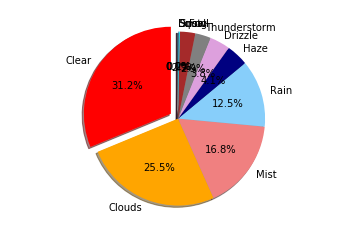

In [27]:
weatherlabels = df_from_weather_csv_clean['weather_main'].value_counts().index
weathervalues = df_from_weather_csv_clean['weather_main'].value_counts().values
weathercolors = ["red", "orange", "lightcoral", "lightskyblue", "navy", "plum", "grey", "brown", "aqua", "indigo", "crimson"]
weatherexplode = (0.1, 0, 0, 0, 0, 0, 0,0, 0, 0,0)
plt.axis("equal")
#plt.legend(labels=labels)

plt.pie(weathervalues, explode=weatherexplode, labels=weatherlabels, colors=weathercolors,
        autopct="%1.1f%%", shadow=True, startangle=90)

In [28]:
df_from_weather_csv_clean.describe()     #need to convert units

,dt,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id
count,1.050100e+04,10501.000000,10501.000000,10501.000000,10501.000000,10501.000000,10501.000000,10501.000000,926.000000,14.000000,0.0,10501.000000,10501.000000
mean,1.530589e+09,292.662311,291.220280,294.120566,1017.503857,69.428340,2.634416,132.279116,1.973035,0.650536,NaN,49.032568,705.047138
std,9.282000e+06,9.053352,9.223503,8.938672,5.943152,21.652778,1.509069,113.222627,2.599333,1.220933,NaN,40.612568,154.670155
min,1.514768e+09,263.920000,261.150000,266.150000,994.000000,10.000000,0.000000,0.000000,0.250000,0.175000,NaN,0.000000,200.000000
25%,1.522199e+09,285.940000,284.150000,287.150000,1014.000000,52.000000,2.000000,10.000000,0.380000,0.215000,NaN,1.000000,701.000000
50%,1.530738e+09,293.930000,292.150000,295.150000,1017.000000,74.000000,2.000000,140.000000,0.930000,0.407500,NaN,75.000000,800.000000
75%,1.538914e+09,298.950000,297.150000,300.150000,1021.000000,88.000000,3.000000,190.000000,2.495000,0.440000,NaN,90.000000,801.000000
max,1.546297e+09,315.020000,314.150000,316.150000,1042.000000,100.000000,13.000000,360.000000,19.560000,4.875000,NaN,100.000000,804.000000


In [29]:
#convert temps from K to DegF, wind speeds from m/s to mph, pressure from hPa to mmHg
df_from_weather_csv_clean_imperial = df_from_weather_csv_clean
df_from_weather_csv_clean_imperial["temp"] = (df_from_weather_csv_clean["temp"]-273.15)*(9/5) +32
df_from_weather_csv_clean_imperial["temp_min"] = (df_from_weather_csv_clean["temp_min"]-273.15)*(9/5) +32
df_from_weather_csv_clean_imperial["temp_max"] = (df_from_weather_csv_clean["temp_max"]-273.15)*(9/5) +32
df_from_weather_csv_clean_imperial["wind_speed"] = (df_from_weather_csv_clean["wind_speed"]*3600)/(1609.34)
df_from_weather_csv_clean_imperial["pressure"] = (df_from_weather_csv_clean["pressure"]*0.75006)

In [30]:
df_2018_weather = df_from_weather_csv_clean_imperial

#look at weather describe (all units imperial now)
df_2018_weather.describe()


,dt,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id
count,1.050100e+04,10501.000000,10501.000000,10501.000000,10501.000000,10501.000000,10501.000000,10501.000000,926.000000,14.000000,0.0,10501.000000,10501.000000
mean,1.530589e+09,67.122161,64.526504,69.747019,763.188943,69.428340,5.893035,132.279116,1.973035,0.650536,NaN,49.032568,705.047138
std,9.282000e+06,16.296033,16.602306,16.089610,4.457721,21.652778,3.375699,113.222627,2.599333,1.220933,NaN,40.612568,154.670155
min,1.514768e+09,15.386000,10.400000,19.400000,745.559640,10.000000,0.000000,0.000000,0.250000,0.175000,NaN,0.000000,200.000000
25%,1.522199e+09,55.022000,51.800000,57.200000,760.560840,52.000000,4.473884,10.000000,0.380000,0.215000,NaN,1.000000,701.000000
50%,1.530738e+09,69.404000,66.200000,71.600000,762.811020,74.000000,4.473884,140.000000,0.930000,0.407500,NaN,75.000000,800.000000
75%,1.538914e+09,78.440000,75.200000,80.600000,765.811260,88.000000,6.710826,190.000000,2.495000,0.440000,NaN,90.000000,801.000000
max,1.546297e+09,107.366000,105.800000,109.400000,781.562520,100.000000,29.080244,360.000000,19.560000,4.875000,NaN,100.000000,804.000000


In [31]:
es_df_from_csv_clean =  df_from_csv_clean   # make a copy

#set the dt_iso as the index
df_2018_weather.index = df_2018_weather["dt_iso"]
max_temps_2018 = df_2018_weather.resample('D').max()
min_temps_2018 = df_2018_weather.resample('D').min()
max_temps_2018_day_series = max_temps_2018["temp_max"]
min_temps_2018_day_series = min_temps_2018["temp_min"]
calday_series = min_temps_2018.index

#adding num incidents per day
es_df_from_csv_clean.index = es_df_from_csv_clean["Published Date"]
incident_count = es_df_from_csv_clean.resample('D', how={"Published Date":"count"})
incident_count_series = incident_count["Published Date"]
#incident_count_series.rename("IncidentCount")
#incident_count_series

C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



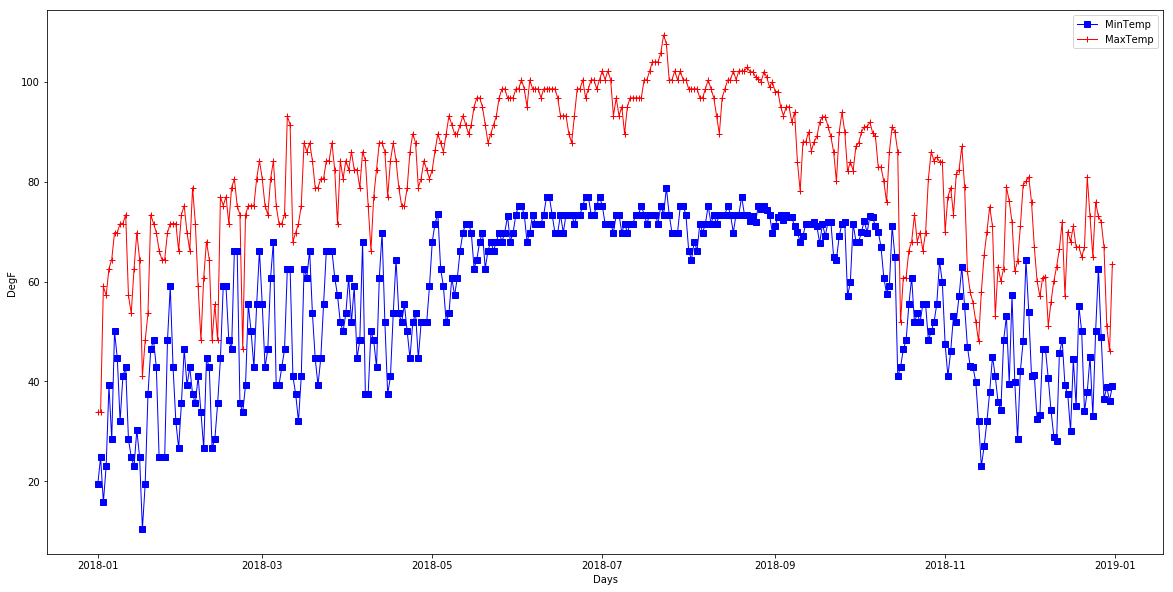

In [32]:
#show min/max temps over the year
# Include this line to make plots interactive
#%matplotlib notebook

plt.figure(figsize=(20,10))

# Create a handle for each plot
MaxTemp, = plt.plot(calday_series, max_temps_2018_day_series, marker="+",color="Red", linewidth=1, label="MaxTemp")
MinTemp, = plt.plot(calday_series, min_temps_2018_day_series, marker="s", color="blue", linewidth=1, label="MinTemp")
#IncCount, = plt.plot(calday_series, incident_count_series, marker="x", color="Black", linewidth=1, label="IncCount")

# Set our legend to where the chart thinks is best
plt.legend(handles=[MinTemp, MaxTemp], loc="best")
#plt.legend(handles=[MinTemp, MaxTemp, IncCount], loc="best")

# Create labels for the X and Y axis
plt.xlabel("Days")
plt.ylabel("DegF")

plt.show()


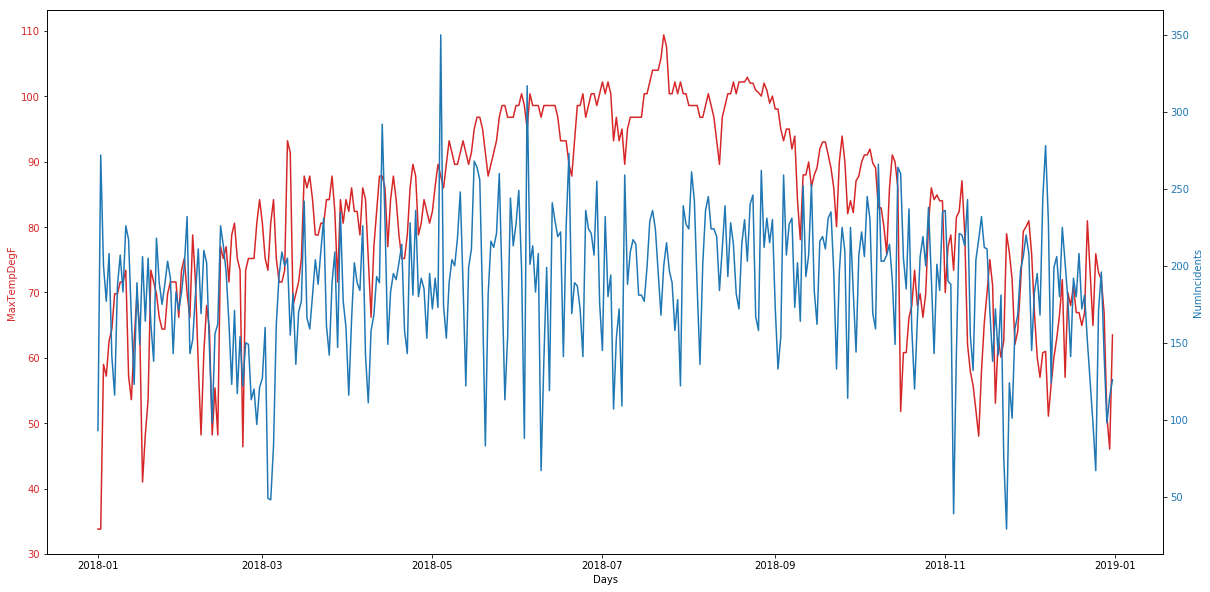

In [33]:
#trying plotting incidents to another y axis
# Include this line to make plots interactive
#%matplotlib notebook

#plt.figure(figsize=(20,10))

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('MaxTempDegF', color=color)
ax1.plot(calday_series, max_temps_2018_day_series, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NumIncidents', color=color)  # we already handled the x-label with ax1
ax2.plot(calday_series, incident_count_series, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.legend(loc=9)   # top center

fig.set_figheight(10)
fig.set_figwidth(20)

plt.show()

Text(0, 0.5, 'DegF')

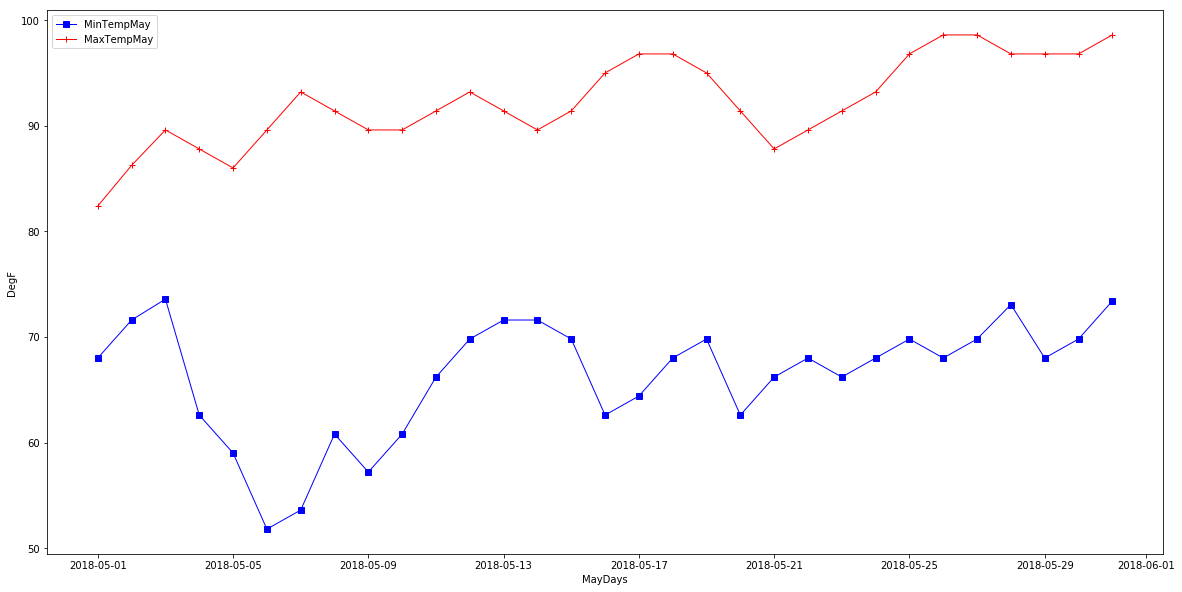

In [34]:
#look at May2018
#max_temps_2018_may = []
#min_temps_2018_may = []

#may mask for temps
may_mask = (df_2018_weather['dt_iso'].dt.month == 5)

#set the dt_iso as the index
#df_2018_weather.index = df_2018_weather["dt_iso"]
df_may = df_2018_weather[may_mask]
max_temps_may_2018 = df_may.resample('D').max()
min_temps_may_2018 = df_may.resample('D').min()
max_temps_2018_may_series = max_temps_may_2018["temp_max"]
min_temps_2018_day_series = min_temps_may_2018["temp_min"]
calday_series = min_temps_2018.index

min_temps_2018_may_series = min_temps_may_2018["temp_min"]
calday_may_series = min_temps_may_2018.index

plt.figure(figsize=(20,10))

# Create a handle for each plot
MaxTempMay, = plt.plot(calday_may_series, max_temps_2018_may_series, marker="+",color="Red", linewidth=1, label="MaxTempMay")
MinTempMay, = plt.plot(calday_may_series, min_temps_2018_may_series, marker="s", color="blue", linewidth=1, label="MinTempMay")

# Set our legend to where the chart thinks is best
plt.legend(handles=[MinTempMay, MaxTempMay], loc="best")

# Create labels for the X and Y axis
plt.xlabel("MayDays")
plt.ylabel("DegF")


C:\Users\rstaveley\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:18: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



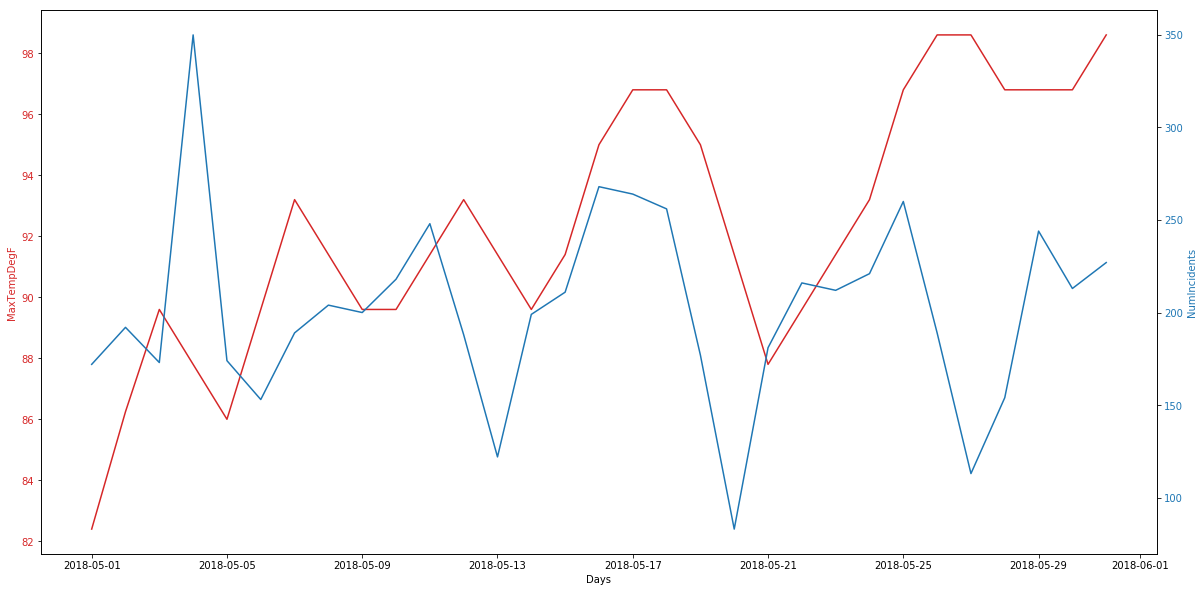

In [35]:
#adding num incidents per day for May


#set may mask
may_mask = (es_df_from_csv_clean["Published Date"].dt.month == 5)

df_may_incidents = es_df_from_csv_clean[may_mask]

max_temps_may_2018 = df_may.resample('D').max()
min_temps_may_2018 = df_may.resample('D').min()
max_temps_2018_may_series = max_temps_may_2018["temp_max"]
#min_temps_2018_day_series = min_temps_may_2018["temp_min"]
calday_may_series = min_temps_may_2018.index



#df_from_csv_clean.index = df_from_csv_clean["Published Date"]
incident_count_may = df_may_incidents.resample('D', how={"Published Date":"count"})
incident_count_may_series = incident_count_may["Published Date"]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('MaxTempDegF', color=color)
ax1.plot(calday_may_series, max_temps_2018_may_series, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NumIncidents', color=color)  # we already handled the x-label with ax1
ax2.plot(calday_may_series, incident_count_may_series, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.legend(loc=9)   # top center

fig.set_figheight(10)
fig.set_figwidth(20)

plt.show()



# Observation:
* As the max temperature trends up from day to day, so do the number of incidents
* As the max temperature trends down from day to day, so does the number of incidents

Is this related to mood (day of the week) or flight response to seek cooler indoor temperatures?

Time for deep diving into specific attributes of the days and incident data.


# Define df's for team member's plotting use

### CREATING analysis_df AS FULL ACCIDENT DATAFRAME

In [36]:
#we will subdivide into these Issues Reported:
#Crash Urgent, Crash Service, COLLISION, COLLISION WITH INJURY, COLLISN/ LVNG SCN, COLLISION/PRIVATE PROPERTY, TRAFFIC FATALITY
analysis_issues = ('CRASH URGENT', 'CRASH SERVICE', 'COLLISION', 'COLLISION WITH INJURY', 'COLLISN/ LVNG SCN', 'COLLISION/PRIVATE PROPERTY', 'TRAFFIC FATALITY')
analysis_df = filtered_df[filtered_df['Issue Reported'].isin(analysis_issues)]
# analysis_df.tail()
len(analysis_df)
#old was  34131...b4 Eric upper cases stuff

34381

### USING TIME MASKS TO CREATE rush_hr_df and no_rush_df FOR CONGESTION COMPARISONS

In [37]:
am_time_mask = (analysis_df['Published Date'].dt.hour >= 0) & \
           (analysis_df['Published Date'].dt.hour <= 5)
am_report_df = analysis_df[am_time_mask]
# am_report_df.head()

In [38]:
mid_time_mask = (analysis_df['Published Date'].dt.hour >= 9) & \
           (analysis_df['Published Date'].dt.hour <= 15)
mid_report_df = analysis_df[mid_time_mask]
# mid_report_df.head()

In [39]:
pm_time_mask = (analysis_df['Published Date'].dt.hour >= 19) & \
           (analysis_df['Published Date'].dt.hour <= 24)
pm_report_df = analysis_df[pm_time_mask]
# pm_report_df.head()

In [40]:
non_rush_1_df = am_report_df.append(mid_report_df, ignore_index=True)
# non_rush_1_df.head()

In [41]:
non_rush_df = non_rush_1_df.append(pm_report_df, ignore_index=True)
non_rush_df.head()

,Traffic Report ID,Published Date,Issue Reported,Location,Latitude,Longitude,Address,Status,Status Date
0,69E356FC5B897FF52301D1A4D870E2862A05C244_15324...,2018-07-24 05:40:48,COLLISION,"(30.094498,-97.761155)",30.094498,-97.761155,6700-7940 S SH 45 E WB,ARCHIVED,2018-07-24 06:45:02
1,B039469E10CC32B9EB6AAEE8AABB64A15836746F_15381...,2018-09-29 00:58:05,CRASH SERVICE,"(30.287391,-97.741586)",30.287391,-97.741586,2340 Guadalupe St,ARCHIVED,2018-09-29 01:40:03
2,A0A82EBDD4A855C999B56CE855A244A672DCAFFF_15381...,2018-09-29 00:54:38,CRASH SERVICE,"(30.225971,-97.804548)",30.225971,-97.804548,Jones Rd & West Wind Trl,ARCHIVED,2018-09-29 02:10:03
3,08D67B9F9F6E2794FD86FD4B7E70E8360CCDBEAD_15381...,2018-09-29 02:37:20,CRASH SERVICE,"(30.311435,-97.709675)",30.311435,-97.709675,5200-5226 N Ih 35 Svrd Sb,ARCHIVED,2018-09-29 03:10:02
4,1D533EC2E7D744E1AC9A2E874A5F269093234DF3_15382...,2018-09-30 05:04:56,CRASH URGENT,"(30.411702,-97.722008)",30.411702,-97.722008,Amherst Dr & Duval Rd,ARCHIVED,2018-09-30 06:05:02


In [42]:
non_rush_df.count()

Traffic Report ID    24853
Published Date       24853
Issue Reported       24853
Location             24853
Latitude             24853
Longitude            24853
Address              24853
Status               24853
Status Date          24853
dtype: int64

In [43]:
am_rush_mask = (analysis_df['Published Date'].dt.hour >= 6) & \
           (analysis_df['Published Date'].dt.hour <= 8)
am_rush_df = analysis_df[am_rush_mask]
# am_rush_df.head()



In [44]:
pm_rush_mask = (analysis_df['Published Date'].dt.hour >= 16) & \
           (analysis_df['Published Date'].dt.hour <= 18)
pm_rush_df = analysis_df[pm_rush_mask]
# pm_rush_df.head()

In [45]:
rush_hr_df = am_rush_df.append(pm_rush_df, ignore_index=True)
# rush_hr_df.tail()
#rush_hr_df.count()

# FILTER BY MONTH
### USE (mmm)_report_df for ALL ACCIDENTS in that month
### USE (mmm)_report2_df for NON-RUSH HOUR ACCIDENTS in that month
### USE (mmm)_report3_df for all RUSH HOUR ACCIDENTS in that month

In [46]:
# Filter analysis df and non-rush df by month for plotting
# Generate January report dataframes
jan_mask = (analysis_df['Published Date'].dt.month == 1)
jan_mask2 = (non_rush_df['Published Date'].dt.month == 1)
jan_mask3 = (rush_hr_df['Published Date'].dt.month == 1)
jan_report_df = analysis_df[jan_mask]
jan_report2_df = non_rush_df[jan_mask2]
jan_report3_df = rush_hr_df[jan_mask3]
jan_count = jan_report_df['Published Date'].count()
jan_count2 = jan_report2_df['Published Date'].count()
jan_count3 = jan_report3_df['Published Date'].count()
# jan_count3

In [47]:
# Generate February report dataframes
feb_mask = (analysis_df['Published Date'].dt.month == 2)
feb_mask2 = (non_rush_df['Published Date'].dt.month == 2)
feb_mask3 = (rush_hr_df['Published Date'].dt.month == 2)
feb_report_df = analysis_df[feb_mask]
feb_report2_df = non_rush_df[feb_mask2]
feb_report3_df = rush_hr_df[feb_mask3]
feb_count = feb_report_df['Published Date'].count()
feb_count2 = feb_report2_df['Published Date'].count()
feb_count3 = feb_report3_df['Published Date'].count()

In [48]:
# Generate March report dataframes
mar_mask = (analysis_df['Published Date'].dt.month == 3)
mar_mask2 = (non_rush_df['Published Date'].dt.month == 3)
mar_mask3 = (rush_hr_df['Published Date'].dt.month == 3)
mar_report_df = analysis_df[mar_mask]
mar_report2_df = non_rush_df[mar_mask2]
mar_report3_df = rush_hr_df[mar_mask3]
mar_count = mar_report_df['Published Date'].count()
mar_count2 = mar_report2_df['Published Date'].count()
mar_count3 = mar_report3_df['Published Date'].count()

In [49]:
# Generate April report dataframes
apr_mask = (analysis_df['Published Date'].dt.month == 4)
apr_mask2 = (non_rush_df['Published Date'].dt.month == 4)
apr_mask3 = (rush_hr_df['Published Date'].dt.month == 4)
apr_report_df = analysis_df[apr_mask]
apr_report2_df = non_rush_df[apr_mask2]
apr_report3_df = rush_hr_df[apr_mask3]
apr_count = apr_report_df['Published Date'].count()
apr_count2 = apr_report2_df['Published Date'].count()
apr_count3 = apr_report3_df['Published Date'].count()

In [50]:
# Generate May report dataframes
may_mask = (analysis_df['Published Date'].dt.month == 5)
may_mask2 = (non_rush_df['Published Date'].dt.month == 5)
may_mask3 = (rush_hr_df['Published Date'].dt.month == 5)
may_report_df = analysis_df[may_mask]
may_report2_df = non_rush_df[may_mask2]
may_report3_df = rush_hr_df[may_mask3]
may_count = may_report_df['Published Date'].count()
may_count2 = may_report2_df['Published Date'].count()
may_count3 = may_report3_df['Published Date'].count()

In [51]:
# Generate June report dataframes
jun_mask = (analysis_df['Published Date'].dt.month == 6)
jun_mask2 = (non_rush_df['Published Date'].dt.month == 6)
jun_mask3 = (rush_hr_df['Published Date'].dt.month == 6)
jun_report_df = analysis_df[jun_mask]
jun_report2_df = non_rush_df[jun_mask2]
jun_report3_df = rush_hr_df[jun_mask3]
jun_count = jun_report_df['Published Date'].count()
jun_count2 = jun_report2_df['Published Date'].count()
jun_count3 = jun_report3_df['Published Date'].count()

In [52]:
# Generate July report dataframes
jul_mask = (analysis_df['Published Date'].dt.month == 7)
jul_mask2 = (non_rush_df['Published Date'].dt.month == 7)
jul_mask3 = (rush_hr_df['Published Date'].dt.month == 7)
jul_report_df = analysis_df[jul_mask]
jul_report2_df = non_rush_df[jul_mask2]
jul_report3_df = rush_hr_df[jul_mask3]
jul_count = jul_report_df['Published Date'].count()
jul_count2 = jul_report2_df['Published Date'].count()
jul_count3 = jul_report3_df['Published Date'].count()

In [53]:
# Generate August report dataframes
aug_mask = (analysis_df['Published Date'].dt.month == 8)
aug_mask2 = (non_rush_df['Published Date'].dt.month == 8)
aug_mask3 = (rush_hr_df['Published Date'].dt.month == 8)
aug_report_df = analysis_df[aug_mask]
aug_report2_df = non_rush_df[aug_mask2]
aug_report3_df = rush_hr_df[aug_mask3]
aug_count = aug_report_df['Published Date'].count()
aug_count2 = aug_report2_df['Published Date'].count()
aug_count3 = aug_report3_df['Published Date'].count()

In [54]:
# Generate September report dataframes
sep_mask = (analysis_df['Published Date'].dt.month == 9)
sep_mask2 = (non_rush_df['Published Date'].dt.month == 9)
sep_mask3 = (rush_hr_df['Published Date'].dt.month == 9)
sep_report_df = analysis_df[sep_mask]
sep_report2_df = non_rush_df[sep_mask2]
sep_report3_df = rush_hr_df[sep_mask3]
sep_count = sep_report_df['Published Date'].count()
sep_count2 = sep_report2_df['Published Date'].count()
sep_count3 = sep_report3_df['Published Date'].count()

In [55]:
# Generate October report dataframes
oct_mask = (analysis_df['Published Date'].dt.month == 10)
oct_mask2 = (non_rush_df['Published Date'].dt.month == 10)
oct_mask3 = (rush_hr_df['Published Date'].dt.month == 10)
oct_report_df = analysis_df[oct_mask]
oct_report2_df = non_rush_df[oct_mask2]
oct_report3_df = rush_hr_df[oct_mask3]
oct_count = oct_report_df['Published Date'].count()
oct_count2 = oct_report2_df['Published Date'].count()
oct_count3 = oct_report3_df['Published Date'].count()

In [56]:
# Generate November report dataframes
nov_mask = (analysis_df['Published Date'].dt.month == 11)
nov_mask2 = (non_rush_df['Published Date'].dt.month == 11)
nov_mask3 = (rush_hr_df['Published Date'].dt.month == 11)
nov_report_df = analysis_df[nov_mask]
nov_report2_df = non_rush_df[nov_mask2]
nov_report3_df = rush_hr_df[nov_mask3]
nov_count = nov_report_df['Published Date'].count()
nov_count2 = nov_report2_df['Published Date'].count()
nov_count3 = nov_report3_df['Published Date'].count()

In [57]:
# Generate December report dataframes
dec_mask = (analysis_df['Published Date'].dt.month == 12)
dec_mask2 = (non_rush_df['Published Date'].dt.month == 12)
dec_mask3 = (rush_hr_df['Published Date'].dt.month == 12)
dec_report_df = analysis_df[dec_mask]
dec_report2_df = non_rush_df[dec_mask2]
dec_report3_df = rush_hr_df[dec_mask3]
dec_count = dec_report_df['Published Date'].count()
dec_count2 = dec_report2_df['Published Date'].count()
dec_count3 = dec_report3_df['Published Date'].count()
# dec_count2

# FILTER BY DAY OF THE WEEK
### USE (ddd)_all_df for ALL ACCIDENTS in that DAY of the WEEK¶
### USE (ddd)_norush_df for NON-RUSH HOUR ACCIDENTS in that DAY of the WEEK
### USE (ddd)_rushhr_df for all RUSH HOUR ACCIDENTS in that DAY of the WEEK

In [58]:
# Filter analysis df by day of week for plotting
# Generate Monday report dataframes
mon_all_mask = (analysis_df['Published Date'].dt.dayofweek == 0)
mon_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 0)
mon_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 0)
mon_all_df = analysis_df[mon_all_mask]
mon_norush_df = non_rush_df[mon_norush_mask]
mon_rushhr_df = rush_hr_df[mon_rushhr_mask]
mon_all_count = mon_all_df['Published Date'].count()
mon_norush_count = mon_norush_df['Published Date'].count()
mon_rushhr_count = mon_rushhr_df['Published Date'].count()
# mon_report_df.tail()
# mon_norush_count
# mon_rushhr_count

In [59]:
# Generate Tuesday report dataframes
tue_all_mask = (analysis_df['Published Date'].dt.dayofweek == 1)
tue_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 1)
tue_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 1)
tue_all_df = analysis_df[tue_all_mask]
tue_norush_df = non_rush_df[tue_norush_mask]
tue_rushhr_df = rush_hr_df[tue_rushhr_mask]
tue_all_count = tue_all_df['Published Date'].count()
tue_norush_count = tue_norush_df['Published Date'].count()
tue_rushhr_count = tue_rushhr_df['Published Date'].count()

# tue_report_df.tail()
# tue_rushhr_count

In [60]:
# Generate Wednesday report dataframes
wed_all_mask = (analysis_df['Published Date'].dt.dayofweek == 2)
wed_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 2)
wed_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 2)
wed_all_df = analysis_df[wed_all_mask]
wed_norush_df = non_rush_df[wed_norush_mask]
wed_rushhr_df = rush_hr_df[wed_rushhr_mask]
wed_all_count = wed_all_df['Published Date'].count()
wed_norush_count = wed_norush_df['Published Date'].count()
wed_rushhr_count = wed_rushhr_df['Published Date'].count()

# wed_report_df.tail()
# wed_rushhr_count

In [61]:
# Generate Thursday report dataframes
thu_all_mask = (analysis_df['Published Date'].dt.dayofweek == 3)
thu_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 3)
thu_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 3)
thu_all_df = analysis_df[thu_all_mask]
thu_norush_df = non_rush_df[thu_norush_mask]
thu_rushhr_df = rush_hr_df[thu_rushhr_mask]
thu_all_count = thu_all_df['Published Date'].count()
thu_norush_count = thu_norush_df['Published Date'].count()
thu_rushhr_count = thu_rushhr_df['Published Date'].count()

# thu_report_df.tail()
# thu_rushhr_count

In [62]:
# Generate Friday report dataframes
fri_all_mask = (analysis_df['Published Date'].dt.dayofweek == 4)
fri_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 4)
fri_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 4)
fri_all_df = analysis_df[fri_all_mask]
fri_norush_df = non_rush_df[fri_norush_mask]
fri_rushhr_df = rush_hr_df[fri_rushhr_mask]
fri_all_count = fri_all_df['Published Date'].count()
fri_norush_count = fri_norush_df['Published Date'].count()
fri_rushhr_count = fri_rushhr_df['Published Date'].count()


# fri_report_df.tail()
# fri_rushhr_count

In [63]:
# Generate Saturday report dataframes
sat_all_mask = (analysis_df['Published Date'].dt.dayofweek == 5)
sat_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 5)
sat_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 5)
sat_all_df = analysis_df[sat_all_mask]
sat_norush_df = non_rush_df[sat_norush_mask]
sat_rushhr_df = rush_hr_df[sat_rushhr_mask]
sat_all_count = sat_all_df['Published Date'].count()
sat_norush_count = sat_norush_df['Published Date'].count()
sat_rushhr_count = sat_rushhr_df['Published Date'].count()

# sat_report_df.tail()
# sat_rushhr_count

In [64]:
# Generate Sunday report dataframes
sun_all_mask = (analysis_df['Published Date'].dt.dayofweek == 6)
sun_norush_mask = (non_rush_df['Published Date'].dt.dayofweek == 6)
sun_rushhr_mask = (rush_hr_df['Published Date'].dt.dayofweek == 6)
sun_all_df = analysis_df[sun_all_mask]
sun_norush_df = non_rush_df[sun_norush_mask]
sun_rushhr_df = rush_hr_df[sun_rushhr_mask]
sun_all_count = sun_all_df['Published Date'].count()
sun_norush_count = sun_norush_df['Published Date'].count()
sun_rushhr_count = sun_rushhr_df['Published Date'].count()

# sun_report_df.tail()
# sun_rushhr_count

# FILTER BY HOUR
### USE hr_(##)_all_df for ALL ACCIDENTS in that HOUR of the DAY¶

In [65]:
# Filter analysis dataframe by time of the day for plotting
# Generate Midnight to 1am report dataframes
hr_00_mask = (analysis_df['Published Date'].dt.hour == 0)
hr_00_all_df = analysis_df[hr_00_mask]
hr_00_all_count = hr_00_all_df['Published Date'].count()
# hr_00_all_count

In [66]:
# Generate 1am to 2am report dataframes
hr_01_mask = (analysis_df['Published Date'].dt.hour == 1)
hr_01_all_df = analysis_df[hr_01_mask]
hr_01_all_count = hr_01_all_df['Published Date'].count()
# hr_01_all_count

In [67]:
# Generate 2am to 3am report dataframes
hr_02_mask = (analysis_df['Published Date'].dt.hour == 2)
hr_02_all_df = analysis_df[hr_02_mask]
hr_02_all_count = hr_02_all_df['Published Date'].count()
# hr_02_all_count

In [68]:
# Generate 3am to 4am report dataframes
hr_03_mask = (analysis_df['Published Date'].dt.hour == 3)
hr_03_all_df = analysis_df[hr_03_mask]
hr_03_all_count = hr_03_all_df['Published Date'].count()
# hr_03_all_count

In [69]:
# Generate 4am to 5am report dataframes
hr_04_mask = (analysis_df['Published Date'].dt.hour == 4)
hr_04_all_df = analysis_df[hr_04_mask]
hr_04_all_count = hr_04_all_df['Published Date'].count()
# hr_04_all_count

In [70]:
# Generate 5am to 6am report dataframes
hr_05_mask = (analysis_df['Published Date'].dt.hour == 5)
hr_05_all_df = analysis_df[hr_05_mask]
hr_05_all_count = hr_05_all_df['Published Date'].count()
# hr_05_all_count

In [71]:
# Generate 6am to 7am report dataframes
hr_06_mask = (analysis_df['Published Date'].dt.hour == 6)
hr_06_all_df = analysis_df[hr_06_mask]
hr_06_all_count = hr_06_all_df['Published Date'].count()
# hr_06_all_count

In [72]:
# Generate 7am to 8am report dataframes
hr_07_mask = (analysis_df['Published Date'].dt.hour == 7)
hr_07_all_df = analysis_df[hr_07_mask]
hr_07_all_count = hr_07_all_df['Published Date'].count()
# hr_07_all_count

In [73]:
# Generate 8am to 9am report dataframes
hr_08_mask = (analysis_df['Published Date'].dt.hour == 8)
hr_08_all_df = analysis_df[hr_08_mask]
hr_08_all_count = hr_08_all_df['Published Date'].count()
# hr_08_all_count

In [74]:
# Generate 9am to 10am report dataframes
hr_09_mask = (analysis_df['Published Date'].dt.hour == 9)
hr_09_all_df = analysis_df[hr_09_mask]
hr_09_all_count = hr_09_all_df['Published Date'].count()
# hr_09_all_count

In [75]:
# Generate 10am to 11am report dataframes
hr_10_mask = (analysis_df['Published Date'].dt.hour == 10)
hr_10_all_df = analysis_df[hr_10_mask]
hr_10_all_count = hr_10_all_df['Published Date'].count()
# hr_10_all_count

In [76]:
# Generate 11am to Noon report dataframes
hr_11_mask = (analysis_df['Published Date'].dt.hour == 11)
hr_11_all_df = analysis_df[hr_11_mask]
hr_11_all_count = hr_11_all_df['Published Date'].count()
# hr_11_all_count

In [77]:
# Generate Noon to 1pm report dataframes
hr_12_mask = (analysis_df['Published Date'].dt.hour == 12)
hr_12_all_df = analysis_df[hr_12_mask]
hr_12_all_count = hr_12_all_df['Published Date'].count()
# hr_12_all_count

In [78]:
# Generate 1pm to 2pm report dataframes
hr_13_mask = (analysis_df['Published Date'].dt.hour == 13)
hr_13_all_df = analysis_df[hr_13_mask]
hr_13_all_count = hr_13_all_df['Published Date'].count()
# hr_13_all_count

In [79]:
# Generate 2pm to 3pm report dataframes
hr_14_mask = (analysis_df['Published Date'].dt.hour == 14)
hr_14_all_df = analysis_df[hr_14_mask]
hr_14_all_count = hr_14_all_df['Published Date'].count()
# hr_14_all_count

In [80]:
# Generate 3pm to 4pm report dataframes
hr_15_mask = (analysis_df['Published Date'].dt.hour == 15)
hr_15_all_df = analysis_df[hr_15_mask]
hr_15_all_count = hr_15_all_df['Published Date'].count()
# hr_15_all_count

In [81]:
# Generate 4pm to 5pm report dataframes
hr_16_mask = (analysis_df['Published Date'].dt.hour == 16)
hr_16_all_df = analysis_df[hr_16_mask]
hr_16_all_count = hr_16_all_df['Published Date'].count()
# hr_16_all_count

In [82]:
# Generate 5pm to 6pm report dataframes
hr_17_mask = (analysis_df['Published Date'].dt.hour == 17)
hr_17_all_df = analysis_df[hr_17_mask]
hr_17_all_count = hr_17_all_df['Published Date'].count()
# hr_17_all_count

In [83]:
# Generate 6pm to 7pm report dataframes
hr_18_mask = (analysis_df['Published Date'].dt.hour == 18)
hr_18_all_df = analysis_df[hr_18_mask]
hr_18_all_count = hr_18_all_df['Published Date'].count()
# hr_18_all_count

In [84]:
# Generate 7pm to 8pm report dataframes
hr_19_mask = (analysis_df['Published Date'].dt.hour == 19)
hr_19_all_df = analysis_df[hr_19_mask]
hr_19_all_count = hr_19_all_df['Published Date'].count()
# hr_19_all_count

In [85]:
# Generate 8pm to 9pm report dataframes
hr_20_mask = (analysis_df['Published Date'].dt.hour == 20)
hr_20_all_df = analysis_df[hr_20_mask]
hr_20_all_count = hr_20_all_df['Published Date'].count()
# hr_20_all_count

In [86]:
# Generate 9pm to 10pm report dataframes
hr_21_mask = (analysis_df['Published Date'].dt.hour == 21)
hr_21_all_df = analysis_df[hr_21_mask]
hr_21_all_count = hr_21_all_df['Published Date'].count()
# hr_21_all_count

In [87]:
# Generate 10pm to 11pm report dataframes
hr_22_mask = (analysis_df['Published Date'].dt.hour == 22)
hr_22_all_df = analysis_df[hr_22_mask]
hr_22_all_count = hr_22_all_df['Published Date'].count()
# hr_22_all_count

In [88]:
# Generate 11pm to Midnight report dataframes
hr_23_mask = (analysis_df['Published Date'].dt.hour == 23)
hr_23_all_df = analysis_df[hr_23_mask]
hr_23_all_count = hr_23_all_df['Published Date'].count()
# hr_23_all_count

# PLOTS FOR ANALYSIS

### Using Plotly for analysis

In [89]:
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

## Accident Totals by Day of the Week - 2018

In [90]:
trace1 = go.Bar(
    x=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"],
    y=[
    mon_rushhr_count, tue_rushhr_count, wed_rushhr_count, thu_rushhr_count, fri_rushhr_count, sat_rushhr_count, sun_rushhr_count
],
    name='Rush Hour Accidents'
)
trace2 = go.Bar(
    x=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"],
    y=[
    mon_norush_count, tue_norush_count, wed_norush_count, thu_norush_count, fri_norush_count, sat_norush_count, sun_norush_count
],
    name='Non-rush Hour Accidents'
)

In [91]:
data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accident Totals by Hour of the Day - all days in 2018

In [92]:
trace3 = go.Bar(
    x=[
    "0000", "0100", "0200", "0300", "0400", "0500", "0600", "0700", "0800", "0900", "1000", "1100",
    "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300"
      ],
    y=[
    hr_00_all_count, hr_01_all_count, hr_02_all_count, hr_03_all_count, hr_04_all_count, hr_05_all_count,
    hr_06_all_count, hr_07_all_count, hr_08_all_count, hr_09_all_count, hr_10_all_count, hr_11_all_count,
    hr_12_all_count, hr_13_all_count, hr_14_all_count, hr_15_all_count, hr_16_all_count, hr_17_all_count,
    hr_18_all_count, hr_19_all_count, hr_20_all_count, hr_21_all_count, hr_22_all_count, hr_23_all_count,        
],
    name='Accidents by Hour'
)

In [93]:
data = [trace3]
layout = go.Layout(
    barmode='stack',
    title='Accident Totals by Hour of the Day - all days in 2018'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accident Totals by Hour of the Day - Fridays in 2018

In [94]:
# Filter by Hour and Day - Friday
hr_00_Fri_df = hr_00_all_df['Published Date'].dt.dayofweek == 4
hr_00_Fri_df_count = hr_00_Fri_df.count()
hr_01_Fri_df = hr_01_all_df['Published Date'].dt.dayofweek == 4
hr_01_Fri_df_count = hr_01_Fri_df.count()
hr_02_Fri_df = hr_02_all_df['Published Date'].dt.dayofweek == 4
hr_02_Fri_df_count = hr_02_Fri_df.count()
hr_03_Fri_df = hr_03_all_df['Published Date'].dt.dayofweek == 4
hr_03_Fri_df_count = hr_03_Fri_df.count()
hr_04_Fri_df = hr_04_all_df['Published Date'].dt.dayofweek == 4
hr_04_Fri_df_count = hr_04_Fri_df.count()
hr_05_Fri_df = hr_05_all_df['Published Date'].dt.dayofweek == 4
hr_05_Fri_df_count = hr_05_Fri_df.count()
hr_06_Fri_df = hr_06_all_df['Published Date'].dt.dayofweek == 4
hr_06_Fri_df_count = hr_06_Fri_df.count()
hr_07_Fri_df = hr_07_all_df['Published Date'].dt.dayofweek == 4
hr_07_Fri_df_count = hr_07_Fri_df.count()
hr_08_Fri_df = hr_08_all_df['Published Date'].dt.dayofweek == 4
hr_08_Fri_df_count = hr_08_Fri_df.count()
hr_09_Fri_df = hr_09_all_df['Published Date'].dt.dayofweek == 4
hr_09_Fri_df_count = hr_09_Fri_df.count()
hr_10_Fri_df = hr_10_all_df['Published Date'].dt.dayofweek == 4
hr_10_Fri_df_count = hr_10_Fri_df.count()
hr_11_Fri_df = hr_11_all_df['Published Date'].dt.dayofweek == 4
hr_11_Fri_df_count = hr_11_Fri_df.count()
hr_12_Fri_df = hr_12_all_df['Published Date'].dt.dayofweek == 4
hr_12_Fri_df_count = hr_12_Fri_df.count()
hr_13_Fri_df = hr_13_all_df['Published Date'].dt.dayofweek == 4
hr_13_Fri_df_count = hr_13_Fri_df.count()
hr_14_Fri_df = hr_14_all_df['Published Date'].dt.dayofweek == 4
hr_14_Fri_df_count = hr_14_Fri_df.count()
hr_15_Fri_df = hr_15_all_df['Published Date'].dt.dayofweek == 4
hr_15_Fri_df_count = hr_15_Fri_df.count()
hr_15_Fri_df = hr_15_all_df['Published Date'].dt.dayofweek == 4
hr_15_Fri_df_count = hr_15_Fri_df.count()
hr_16_Fri_df = hr_16_all_df['Published Date'].dt.dayofweek == 4
hr_16_Fri_df_count = hr_16_Fri_df.count()
hr_17_Fri_df = hr_17_all_df['Published Date'].dt.dayofweek == 4
hr_17_Fri_df_count = hr_17_Fri_df.count()
hr_18_Fri_df = hr_18_all_df['Published Date'].dt.dayofweek == 4
hr_18_Fri_df_count = hr_18_Fri_df.count()
hr_19_Fri_df = hr_19_all_df['Published Date'].dt.dayofweek == 4
hr_19_Fri_df_count = hr_19_Fri_df.count()
hr_20_Fri_df = hr_20_all_df['Published Date'].dt.dayofweek == 4
hr_20_Fri_df_count = hr_20_Fri_df.count()
hr_21_Fri_df = hr_21_all_df['Published Date'].dt.dayofweek == 4
hr_21_Fri_df_count = hr_21_Fri_df.count()
hr_22_Fri_df = hr_22_all_df['Published Date'].dt.dayofweek == 4
hr_22_Fri_df_count = hr_22_Fri_df.count()
hr_23_Fri_df = hr_23_all_df['Published Date'].dt.dayofweek == 4
hr_23_Fri_df_count = hr_23_Fri_df.count()

In [95]:
trace6 = go.Bar(
    x=[
    "0000", "0100", "0200", "0300", "0400", "0500", "0600", "0700", "0800", "0900", "1000", "1100",
    "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300"
      ],
    y=[
    hr_00_Fri_df_count, hr_01_Fri_df_count, hr_02_Fri_df_count, hr_03_Fri_df_count, hr_04_Fri_df_count, hr_05_Fri_df_count,
    hr_06_Fri_df_count, hr_07_Fri_df_count, hr_08_Fri_df_count, hr_09_Fri_df_count, hr_10_Fri_df_count, hr_11_Fri_df_count,
    hr_12_Fri_df_count, hr_13_Fri_df_count, hr_14_Fri_df_count, hr_15_Fri_df_count, hr_16_Fri_df_count, hr_17_Fri_df_count,
    hr_18_Fri_df_count, hr_19_Fri_df_count, hr_20_Fri_df_count, hr_21_Fri_df_count, hr_22_Fri_df_count, hr_23_Fri_df_count,        
],
    name='Accidents by Hour on Friday'
)

In [96]:
data = [trace6]
layout = go.Layout(
    barmode='stack',
    title='Accident Totals by Hour in the Day - Fridays in 2018'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accident Totals by Month - 2018

In [97]:
trace1 = go.Bar(
    x=["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"],
    y=[
    jan_count3, feb_count3, mar_count3, apr_count3, may_count3, jun_count3,
    jul_count3, aug_count3, sep_count3, oct_count3, nov_count3, dec_count3
],
    name='Rush Hour Accidents'
)
trace2 = go.Bar(
    x=["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"],
    y=[
    jan_count2, feb_count2, mar_count2, apr_count2, may_count2, jun_count2,
    jul_count2, aug_count2, sep_count2, oct_count2, nov_count2, dec_count2
],
    name='Non-rush Hour Accidents'
)

In [98]:
data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Accident Totals by Month - 2018'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Take a closer look at May and October
## Accidents by Day of the Week - May 2018

In [99]:
may_mon_df = (mon_all_df['Published Date'].dt.month == 5)
may_tue_df = (tue_all_df['Published Date'].dt.month == 5)
may_wed_df = (wed_all_df['Published Date'].dt.month == 5)
may_thu_df = (thu_all_df['Published Date'].dt.month == 5)
may_fri_df = (fri_all_df['Published Date'].dt.month == 5)
may_sat_df = (sat_all_df['Published Date'].dt.month == 5)
may_sun_df = (sun_all_df['Published Date'].dt.month == 5)
may_mon_count = may_mon_df.count()
may_tue_count = may_tue_df.count()
may_wed_count = may_wed_df.count()
may_thu_count = may_thu_df.count()
may_fri_count = may_fri_df.count()
may_sat_count = may_sat_df.count()
may_sun_count = may_sun_df.count()
# may_mon_df.count()

In [100]:
trace8 = go.Bar(
    x=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"],
    y=[may_mon_count, may_tue_count, may_wed_count, may_thu_count, may_fri_count, may_sat_count, may_sun_count],
    name='Accidents by Day in May'
)

In [101]:
data = [trace8]
layout = go.Layout(
    barmode='stack',
    title='Accidents by Day of the Week - May 2018'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Accidents by Date - May 2018

In [102]:
may_daily_count = may_report_df.groupby(by=may_report_df['Published Date'].dt.date).count()
may_accident_days = may_daily_count['Issue Reported']
# may_accident_days.values

In [103]:
may_accident_days.index

may_index = may_accident_days.index
# may_index

In [104]:
trace10 = go.Scatter(
    x=may_accident_days.index,
    y=may_accident_days.values,
    name='Accidents by Date in May'
)

In [105]:
data = [trace10]
layout = go.Layout(
    title='Accidents by Date - May 2018'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [106]:
trace9 = go.Bar(
    x=may_accident_days.index,
    y=may_accident_days.values,
    name='Accidents by Date in May'
)

In [107]:
data = [trace9]
layout = go.Layout(
    barmode='stack',
    title='Accidents by Date - May 2018'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Taking a Closer Look at Wednesday May 16, 2018

In [108]:
# Filter by Hour and Day -_wednesday, May 16
# wed_all_mask = analysis_df['Published Date'].dt.dayofweek == 2
# wed_all_df = analysis_df[wed_all_mask
wed_16_df = analysis_df['Published Date'].dt.date == 2018-5-16

hr_00_wed_16_df = wed_16_df[hr_00_mask]
hr_00_wed_16_df_count = hr_00_wed_16_df.count()
hr_01_wed_16_df = wed_16_df[hr_01_mask]
hr_01_wed_16_df_count = hr_01_wed_16_df.count()
hr_02_wed_16_df = wed_16_df[hr_02_mask]
hr_02_wed_16_df_count = hr_02_wed_16_df.count()
hr_03_wed_16_df = wed_16_df[hr_03_mask]
hr_03_wed_16_df_count = hr_03_wed_16_df.count()
hr_04_wed_16_df = wed_16_df[hr_04_mask]
hr_04_wed_16_df_count = hr_04_wed_16_df.count()
hr_05_wed_16_df = wed_16_df[hr_05_mask]
hr_05_wed_16_df_count = hr_05_wed_16_df.count()
hr_06_wed_16_df = wed_16_df[hr_06_mask]
hr_06_wed_16_df_count = hr_06_wed_16_df.count()
hr_07_wed_16_df = wed_16_df[hr_07_mask]
hr_07_wed_16_df_count = hr_07_wed_16_df.count()
hr_08_wed_16_df = wed_16_df[hr_08_mask]
hr_08_wed_16_df_count = hr_08_wed_16_df.count()
hr_09_wed_16_df = wed_16_df[hr_09_mask]
hr_09_wed_16_df_count = hr_09_wed_16_df.count()
hr_10_wed_16_df = wed_16_df[hr_10_mask]
hr_10_wed_16_df_count = hr_10_wed_16_df.count()
hr_11_wed_16_df = wed_16_df[hr_11_mask]
hr_11_wed_16_df_count = hr_11_wed_16_df.count()
hr_12_wed_16_df = wed_16_df[hr_12_mask]
hr_12_wed_16_df_count = hr_12_wed_16_df.count()
hr_13_wed_16_df = wed_16_df[hr_13_mask]
hr_13_wed_16_df_count = hr_13_wed_16_df.count()
hr_14_wed_16_df = wed_16_df[hr_14_mask]
hr_14_wed_16_df_count = hr_14_wed_16_df.count()
hr_15_wed_16_df = wed_16_df[hr_15_mask]
hr_15_wed_16_df_count = hr_15_wed_16_df.count()
hr_16_wed_16_df = wed_16_df[hr_16_mask]
hr_16_wed_16_df_count = hr_16_wed_16_df.count()
hr_17_wed_16_df = wed_16_df[hr_17_mask]
hr_17_wed_16_df_count = hr_17_wed_16_df.count()
hr_18_wed_16_df = wed_16_df[hr_18_mask]
hr_18_wed_16_df_count = hr_18_wed_16_df.count()
hr_19_wed_16_df = wed_16_df[hr_19_mask]
hr_19_wed_16_df_count = hr_19_wed_16_df.count()
hr_20_wed_16_df = wed_16_df[hr_20_mask]
hr_20_wed_16_df_count = hr_20_wed_16_df.count()
hr_21_wed_16_df = wed_16_df[hr_21_mask]
hr_21_wed_16_df_count = hr_21_wed_16_df.count()
hr_22_wed_16_df = wed_16_df[hr_22_mask]
hr_22_wed_16_df_count = hr_22_wed_16_df.count()
hr_23_wed_16_df = wed_16_df[hr_23_mask]
hr_23_wed_16_df_count = hr_23_wed_16_df.count()

In [109]:
trace10 = go.Bar(
    x=[
    "0000", "0100", "0200", "0300", "0400", "0500", "0600", "0700", "0800", "0900", "1000", "1100",
    "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200", "2300"
      ],
    y=[
    hr_00_wed_16_df_count, hr_01_wed_16_df_count, hr_02_wed_16_df_count, hr_03_wed_16_df_count, hr_04_wed_16_df_count, hr_05_wed_16_df_count,
    hr_06_wed_16_df_count, hr_07_wed_16_df_count, hr_08_wed_16_df_count, hr_09_wed_16_df_count, hr_10_wed_16_df_count, hr_11_wed_16_df_count,
    hr_12_wed_16_df_count, hr_13_wed_16_df_count, hr_14_wed_16_df_count, hr_15_wed_16_df_count, hr_16_wed_16_df_count, hr_17_wed_16_df_count,
    hr_18_wed_16_df_count, hr_19_wed_16_df_count, hr_20_wed_16_df_count, hr_21_wed_16_df_count, hr_22_wed_16_df_count, hr_23_wed_16_df_count,        
],
    name='Accidents by Hour on May 16, 2018'
)

In [110]:
data = [trace10]
layout = go.Layout(
    barmode='stack',
    title='Accidents by Hour on May 16, 2018'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [111]:
# code to take the lat and long and make a list for gmap

aus_lat = df_from_csv_clean["Latitude"]    #series
aus_long = df_from_csv_clean["Longitude"]    #series

aus_lat_subset = aus_lat.head(1000)   #make a subset to test
aus_long_subset = aus_long.head(1000)  # make a subset to test

#print(type(aus_lat_subset))     #its a series
#print(aus_lat_subset[0])        #whats the value?
#print(type(aus_lat_subset[0]))    #its a string

#print(aus_lat_subset)   #show the whole lat subset

#using zip function to zip the lat and long together to a list with each element being a tuple
aus_lat_long_list_subset = list(zip(aus_lat_subset, aus_long_subset))
aus_lat_long_list = list(zip(aus_lat, aus_long))

#print(aus_lat_long_list_subset)
#type(aus_lat_long_list_subset[0])    #each element is a tuple...yay!

In [112]:
# Customize the size of the figure      was   400 x 300
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [113]:
# Assign the marker layer to a variable  ..      DOING THE SUBSET HERE... TAKES ABOUT 10sec  

#help(gmaps.marker_layer)

markers = gmaps.marker_layer(aus_lat_long_list_subset)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

In [114]:
#help(gmaps.marker_layer)
#extracting the marker image is a bit different than plt.savefig....basically
#gmaps only lets you save the .html  OR  you can manually dload the fig 
#within the display frame
#per https://jupyter-gmaps.readthedocs.io/en/latest/export.html
#
#to export:
#from ipywidgets.embed import embed_minimal_html
#embed_minimal_html('exported_filename_here.html', views=[fig])
#
#to open the file:
#python -m http.server 8080
#Navigate to http://0.0.0.0:8080/exported_filename.html and you should see the export!


In [115]:
fig = gmaps.figure(map_type='HYBRID')
heatmap_layer = gmaps.heatmap_layer(aus_lat_long_list_subset)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [116]:
#saving the marker image is a bit different than plt.savefig....basically
#gmaps only lets you save the .html  OR  you can manually dload the fig 
#within the display frame
#per https://jupyter-gmaps.readthedocs.io/en/latest/export.html
#
#to export:
#from ipywidgets.embed import embed_minimal_html
#embed_minimal_html('exported_filename_here.html', views=[fig])
#
#to open the file:
#python -m http.server 8080
#Navigate to http://0.0.0.0:8080/exported_filename.html and you should see the export!